In [2]:
!pip install ortools


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 31.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [3]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910460 sha256=aed5efac1f692beacebfe5f63b0ea2c7e3f81217597a6697cf5b0bb3c9737ff4
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.data import Data
from ortools.constraint_solver import pywrapcp, routing_enums_pb2


Epoch 100, Loss: 4.227481986163184e-05
Epoch 200, Loss: 3.865681355819106e-05
Epoch 300, Loss: 3.571794513845816e-05
Epoch 400, Loss: 3.2912383176153526e-05
Epoch 500, Loss: 3.031283267773688e-05
Epoch 600, Loss: 2.793607382045593e-05
Epoch 700, Loss: 2.5778732378967106e-05
Epoch 800, Loss: 2.382725870120339e-05
Epoch 900, Loss: 2.206224962719716e-05
Epoch 1000, Loss: 2.0461829990381375e-05
Epoch 1100, Loss: 1.9004664864041843e-05
Epoch 1200, Loss: 1.7671645764494315e-05
Epoch 1300, Loss: 1.644667463551741e-05
Epoch 1400, Loss: 1.5316527424147353e-05
Epoch 1500, Loss: 1.4270529391069431e-05
Epoch 1600, Loss: 1.3299903002916835e-05
Epoch 1700, Loss: 1.2397294995025732e-05
Epoch 1800, Loss: 1.1556291610759217e-05
Epoch 1900, Loss: 1.0771344022941776e-05
Epoch 2000, Loss: 1.00374727480812e-05
Epoch 2100, Loss: 9.349803804070689e-06
Epoch 2200, Loss: 8.704549145477358e-06
Epoch 2300, Loss: 8.098676516965497e-06
Epoch 2400, Loss: 7.532795279985294e-06
Epoch 2500, Loss: 6.993600891291862e-06

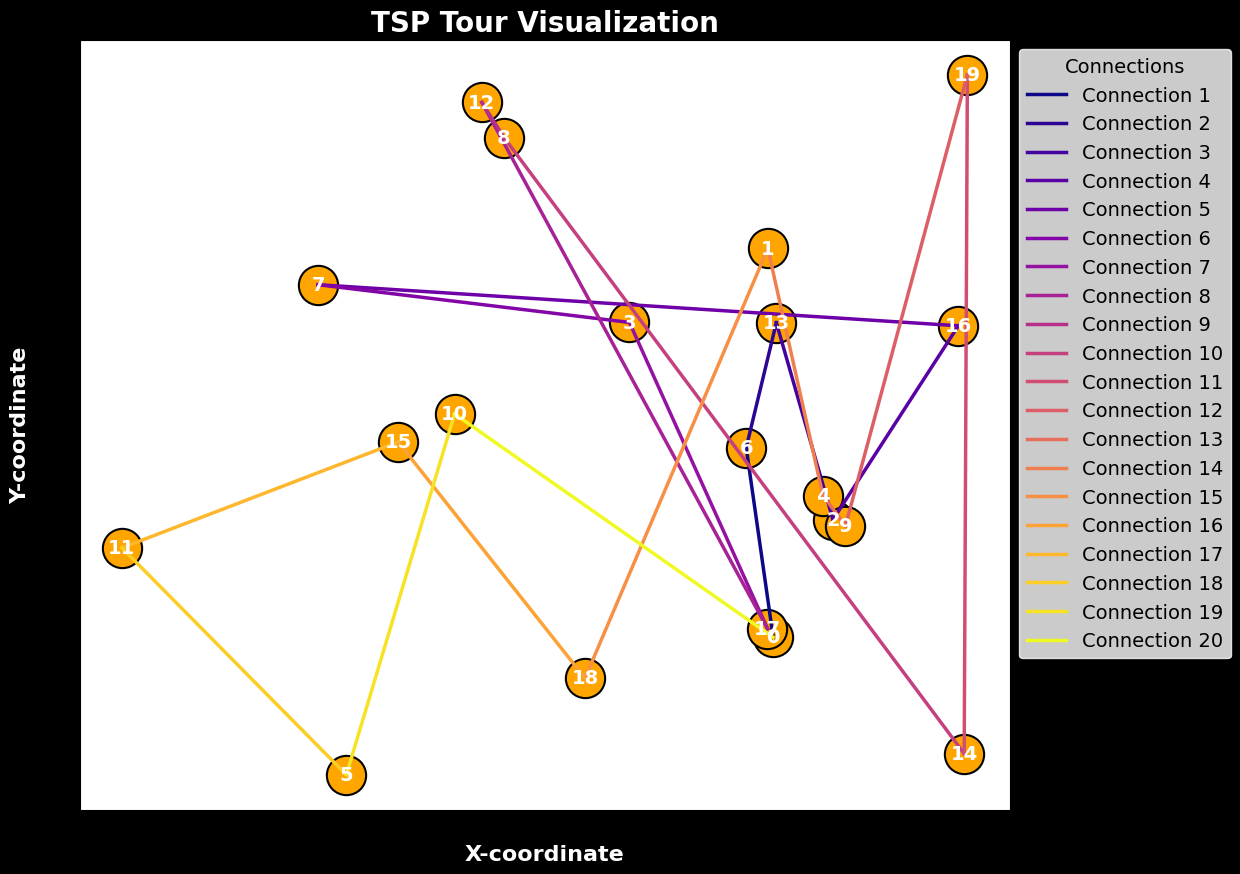

Total Distance Traveled (GNN): 8.800377547740936
Total Distance Traveled (Optimal): 10.493653371930122
Comparison:
GNN's tour is better (shorter distance) than the optimal tour.


In [12]:

class TSP_GNN(nn.Module):
    def __init__(self, num_nodes, hidden_dim):
        super(TSP_GNN, self).__init__()
        self.embedding = nn.Linear(2, hidden_dim)
        self.gat_layer = GATConv(hidden_dim, hidden_dim, heads=1)
        self.gcn_layer = GCNConv(hidden_dim, hidden_dim)
        self.readout = nn.Linear(hidden_dim, 1)
        self.num_nodes = num_nodes

    def forward(self, node_positions, edge_index):
        # Initialize node embeddings and embed the nodes
        node_embeddings = self.embedding(node_positions)

        # Message passing (GAT update)
        node_embeddings = self.gat_layer(node_embeddings, edge_index)

        # Additional GCN layer
        node_embeddings = self.gcn_layer(node_embeddings, edge_index)

        return node_embeddings


# Visualize the TSP tour and city locations
def visualize_tsp_tour(node_positions, tour_order):
    x = node_positions[:, 0]
    y = node_positions[:, 1]
    plt.figure(figsize=(12, 10), facecolor='black')  # Increase the figure size

    num_nodes = node_positions.size(0)
    connections = np.linspace(0, 1, num_nodes)

    # Scatter plot for cities with labels (using city index as the label)
    for i in range(num_nodes):
        plt.scatter(x[i], y[i], c='orange', s=800, zorder=2, edgecolor='black', linewidth=1.5)  # Increase the node size
        plt.text(x[i], y[i], str(i), fontsize=14, ha='center', va='center', color='white', fontweight='bold')  # Display node labels

    # Plot the TSP tour connections with different colors and labels
    for i in range(num_nodes - 1):
        plt.plot([x[tour_order[i]], x[tour_order[i + 1]]], [y[tour_order[i]], y[tour_order[i + 1]]],
                 color=plt.cm.plasma(connections[i]), linewidth=2.5, linestyle='-', label=f'Connection {i + 1}')

    plt.plot([x[tour_order[-1]], x[tour_order[0]]], [y[tour_order[-1]], y[tour_order[0]]],
             color=plt.cm.plasma(connections[-1]), linewidth=2.5, linestyle='-', label=f'Connection {num_nodes}')

    plt.title('TSP Tour Visualization', color='white', fontsize=20, fontweight='bold')  # Update title font style
    plt.xlabel('X-coordinate', color='white', fontsize=16, fontweight='bold')  # Update X-axis label font style
    plt.ylabel('Y-coordinate', color='white', fontsize=16, fontweight='bold')  # Update Y-axis label font style
    plt.xticks(fontsize=14, fontweight='bold')  # Update tick font style
    plt.yticks(fontsize=14, fontweight='bold')  # Update tick font style
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), edgecolor='white', title='Connections', fontsize=14, title_fontsize=14)

    # Remove unnecessary grid lines
    plt.grid(False)

    plt.show()

    return tour_order


# Function to solve TSP optimally using OR-Tools
def solve_tsp_optimal(node_positions):
    num_nodes = node_positions.size(0)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(num_nodes, 1, 0)

    # Create the routing model.
    routing = pywrapcp.RoutingModel(manager)

    # Create distance callback.
    def distance_callback(from_index, to_index):
        return np.linalg.norm(node_positions[from_index] - node_positions[to_index])

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Set the initial solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Get the optimal tour order.
    tour_order = []
    if solution:
        index = routing.Start(0)
        while not routing.IsEnd(index):
            tour_order.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        tour_order.append(manager.IndexToNode(index))

    return tour_order


# Function to calculate the total distance traveled in a tour
def calculate_total_distance(node_positions, tour_order):
    num_nodes = len(tour_order)
    total_distance = 0
    for i in range(num_nodes - 1):
        start_node = tour_order[i]
        end_node = tour_order[i + 1]
        total_distance += np.linalg.norm(node_positions[start_node] - node_positions[end_node])
    # Add distance from the last node back to the starting node
    total_distance += np.linalg.norm(node_positions[tour_order[-1]] - node_positions[tour_order[0]])
    return total_distance


# Generate a random TSP instance with 20 cities
num_nodes = 20
edge_index = torch.randint(num_nodes, (2, num_nodes * num_nodes))
data = Data(node_positions=torch.rand(num_nodes, 2), edge_index=edge_index)

# Create and train the GNN model with the same number of nodes as in the adjacency matrix
model = TSP_GNN(num_nodes, hidden_dim=16)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Generate node positions before training
data.node_positions = torch.rand(num_nodes, 2)

# Training loop
for epoch in range(5000):
    optimizer.zero_grad()
    node_embeddings = get_node_embeddings(model, data)
    loss = criterion(node_embeddings, torch.zeros_like(node_embeddings))  # Loss is the embeddings themselves (no specific target)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

# Visualize the final TSP tour
# Select a starting node (e.g., the first node)
starting_node = 0
distances_from_starting_node = torch.norm(node_embeddings - node_embeddings[starting_node], dim=1)
_, tour_order_gnn = torch.sort(distances_from_starting_node)
visualize_tsp_tour(data.node_positions, tour_order_gnn)

# Solve the TSP optimally using OR-Tools based on the GNN node embeddings
optimal_tour_order = solve_tsp_optimal(data.node_positions)

# Calculate the total distance traveled in each tour
total_distance_gnn = calculate_total_distance(data.node_positions.numpy(), tour_order_gnn)
total_distance_optimal = calculate_total_distance(data.node_positions.numpy(), optimal_tour_order)

# Print the results
print("Total Distance Traveled (GNN):", total_distance_gnn)
print("Total Distance Traveled (Optimal):", total_distance_optimal)

# Compare the total distances of GNN and optimal tours
print("Comparison:")
if total_distance_gnn < total_distance_optimal:
    print("GNN's tour is better (shorter distance) than the optimal tour.")
elif total_distance_gnn > total_distance_optimal:
    print("GNN's tour is worse (longer distance) than the optimal tour.")
else:
    print("GNN's tour and optimal tour have the same total distance.")


In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.nn import GATConv
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

# TSP Graph Neural Network (GNN) model
class TSP_GNN(nn.Module):
    def __init__(self, num_nodes, hidden_dim):
        super(TSP_GNN, self).__init__()
        self.embedding = nn.Linear(2, hidden_dim)
        self.gat_layer = GATConv(hidden_dim, hidden_dim, heads=1)
        self.gcn_layer = GCNConv(hidden_dim, hidden_dim)
        self.readout = nn.Linear(hidden_dim, 1)
        self.num_nodes = num_nodes

    def forward(self, node_positions, edge_index):
        # Initialize node embeddings and embed the nodes
        node_embeddings = self.embedding(node_positions)

        # Message passing (GAT update)
        node_embeddings = self.gat_layer(node_embeddings, edge_index)

        # Additional GCN layer
        node_embeddings = self.gcn_layer(node_embeddings, edge_index)

        return node_embeddings


# Function to get node embeddings using the trained GNN model
def get_node_embeddings(model, data):
    # Use the trained GNN model to get node embeddings
    node_embeddings = model(data.node_positions, data.edge_index)

    return node_embeddings


# Function to solve TSP optimally using OR-Tools
def solve_tsp_optimal(node_positions):
    num_nodes = node_positions.size(0)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(num_nodes, 1, 0)

    # Create the routing model.
    routing = pywrapcp.RoutingModel(manager)

    # Create distance callback.
    def distance_callback(from_index, to_index):
        return np.linalg.norm(node_positions[from_index] - node_positions[to_index])

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Set the initial solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Get the optimal tour order.
    tour_order = []
    if solution:
        index = routing.Start(0)
        while not routing.IsEnd(index):
            tour_order.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        tour_order.append(manager.IndexToNode(index))

    return tour_order


# Function to calculate the total distance traveled in a tour
def calculate_total_distance(node_positions, tour_order):
    num_nodes = len(tour_order)
    total_distance = 0
    for i in range(num_nodes - 1):
        start_node = tour_order[i]
        end_node = tour_order[i + 1]
        total_distance += np.linalg.norm(node_positions[start_node] - node_positions[end_node])
    # Add distance from the last node back to the starting node
    total_distance += np.linalg.norm(node_positions[tour_order[-1]] - node_positions[tour_order[0]])
    return total_distance


# ... (rest of the code)

# Function to run the experiment and count GNN's superiority over optimal tour
def run_experiment(num_nodes, hidden_dim, num_runs):
    total_approximation_ratio = 0
    total_execution_time_gnn = 0
    total_execution_time_ortools = 0
    gnn_superior_count = 0
    optimal_superior_count = 0
    equal_count = 0

    for run in range(num_runs):
        print(f"Running experiment {run + 1}/{num_runs}...")
        edge_index = torch.randint(num_nodes, (2, num_nodes * num_nodes))
        data = Data(node_positions=torch.rand(num_nodes, 2), edge_index=edge_index)

        model = TSP_GNN(num_nodes=num_nodes, hidden_dim=hidden_dim)  # Pass the num_nodes and hidden_dim parameters here
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Generate node positions before training
        data.node_positions = torch.rand(num_nodes, 2)

        for epoch in range(5000):
            optimizer.zero_grad()
            node_embeddings = model(data.node_positions, data.edge_index)
            loss = criterion(node_embeddings, torch.zeros_like(node_embeddings))
            loss.backward()
            optimizer.step()

        # Visualize the final TSP tour found by GNN
        starting_node = 0
        distances_from_starting_node = torch.norm(node_embeddings - node_embeddings[starting_node], dim=1)
        _, tour_order_gnn = torch.sort(distances_from_starting_node)
        visualize_tsp_tour(data.node_positions, tour_order_gnn)

        # Solve the TSP optimally using OR-Tools based on the GNN node embeddings
        start_time_ortools = time.time()
        optimal_tour_order = solve_tsp_optimal(data.node_positions)
        execution_time_ortools = time.time() - start_time_ortools
        total_execution_time_ortools += execution_time_ortools

        # Calculate the total distance traveled in each tour
        total_distance_gnn = calculate_total_distance(data.node_positions, tour_order_gnn)
        total_distance_optimal = calculate_total_distance(data.node_positions, optimal_tour_order)

        # Calculate the approximation ratio
        approximation_ratio = total_distance_gnn / total_distance_optimal
        total_approximation_ratio += approximation_ratio

        # Compare the total distances of GNN and optimal tours
        if total_distance_gnn < total_distance_optimal:
            gnn_superior_count += 1
        elif total_distance_gnn > total_distance_optimal:
            optimal_superior_count += 1
        else:
            equal_count += 1

        # Calculate execution time for GNN
        start_time_gnn = time.time()
        model(data.node_positions, data.edge_index)
        execution_time_gnn = time.time() - start_time_gnn
        total_execution_time_gnn += execution_time_gnn

    # Calculate average approximation ratio and execution times
    avg_approximation_ratio = total_approximation_ratio / num_runs
    avg_execution_time_gnn = total_execution_time_gnn / num_runs
    avg_execution_time_ortools = total_execution_time_ortools / num_runs

    # Print the final results
    print(f"GNN outperformed the optimal tour {gnn_superior_count} times out of {num_runs} runs.")
    print(f"Optimal tour outperformed the GNN {optimal_superior_count} times.")
    print(f"GNN and optimal tour had the same total distance {equal_count} times.")
    print(f"Average Approximation Ratio: {avg_approximation_ratio:.4f}")
    print(f"Average Execution Time GNN (s): {avg_execution_time_gnn:.6f}")
    print(f"Average Execution Time OR-Tools (s): {avg_execution_time_ortools:.6f}")

# ... (rest of the code, including setting parameters and running the experiment)

# Set the parameters for the experiment
num_nodes = 20
hidden_dim = 16
num_runs = 50

# Run the experiment
run_experiment(num_nodes, hidden_dim, num_runs)


Running experiment 1/50...
Running experiment 2/50...
Running experiment 3/50...
Running experiment 4/50...
Running experiment 5/50...
Running experiment 6/50...
Running experiment 7/50...
Running experiment 8/50...
Running experiment 9/50...
Running experiment 10/50...
Running experiment 11/50...
Running experiment 12/50...
Running experiment 13/50...
Running experiment 14/50...
Running experiment 15/50...
Running experiment 16/50...
Running experiment 17/50...
Running experiment 18/50...
Running experiment 19/50...
Running experiment 20/50...
Running experiment 21/50...
Running experiment 22/50...
Running experiment 23/50...
Running experiment 24/50...
Running experiment 25/50...
Running experiment 26/50...
Running experiment 27/50...
Running experiment 28/50...
Running experiment 29/50...
Running experiment 30/50...
Running experiment 31/50...
Running experiment 32/50...
Running experiment 33/50...
Running experiment 34/50...
Running experiment 35/50...
Running experiment 36/50...
R